In [6]:
### import all the dependencies 
import requests
import csv
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from palettable.colorbrewer.qualitative import Pastel1_7  # Inferno_4,Plasma_5,Viridis_6,Viridis_4 
import warnings
warnings.filterwarnings('ignore')

In [7]:
### Main Program starts here  - Now we will read data form CSV

external_customers_df = pd.read_csv("../data/external_customers.csv", low_memory=False)
print('Shape of exports read from CSV : {}'.format(external_customers_df.shape))

Shape of exports read from CSV : (78291, 16)


In [8]:
##List the names of columns 
external_customers_df.columns


Index(['Unnamed: 0', 'Domain', 'UserEmail', 'serviceName', 'UserId', 'IndvId',
       'SessionId', 'PageUrl', 'PageRefererUrl', 'PageBrowser', 'PageDevice',
       'PageDuration', 'PageActiveDuration', 'PageLatLong', 'EventStart',
       'EventType'],
      dtype='object')

In [9]:
len(external_customers_df.columns)

16

In [10]:
## Data Cleaning and filtering 
#dropping an Column not needed 
print('Number of columns before :{}'.format(len(external_customers_df.columns)))
external_customers_df.drop('Unnamed: 0', axis=1, inplace=True)
print('Number of columns after :{}'.format(len(external_customers_df.columns)))

Number of columns before :16
Number of columns after :15


In [11]:
external_customers_df.head()   


,Domain,UserEmail,serviceName,UserId,IndvId,SessionId,PageUrl,PageRefererUrl,PageBrowser,PageDevice,PageDuration,PageActiveDuration,PageLatLong,EventStart,EventType
0,company1.com,chad.tew@Company1.com,Data Logging,5650932471693312,5650932471693312,5629499534213120,https://www.cloud.dataguru.com/li/,https://console.cloud.dataguru.com/bin/gateway...,Chrome,Desktop,20030,3459,"33.3335,-86.9591",2018-09-08T23:10:55.257Z,navigate
1,company1.com,chad.tew@Company1.com,Data Logging,5650932471693312,5650932471693312,5629499534213120,https://www.cloud.dataguru.com/li/,https://console.cloud.dataguru.com/bin/gateway...,Chrome,Desktop,20030,3459,"33.3335,-86.9591",2018-09-08T23:10:56.231Z,load
2,company1.com,chad.tew@Company1.com,Data Logging,5650932471693312,5650932471693312,5629499534213120,https://www.cloud.dataguru.com/li/,https://console.cloud.dataguru.com/bin/gateway...,Chrome,Desktop,20030,3459,"33.3335,-86.9591",2018-09-08T23:11:15.045Z,click
3,company2.com,mike.hutt@Company2.com,SDK,5746562451898368,5767773206609920,5629499534213120,https://www.cloud.dataguru.com/catalog/#/library,https://console.cloud.dataguru.com/bin/gateway...,Chrome,Desktop,2038981,249088,"48.8628,2.3292",2018-09-10T09:33:03.950Z,navigate
4,company2.com,mike.hutt@Company2.com,SDK,5746562451898368,5767773206609920,5629499534213120,https://www.cloud.dataguru.com/catalog/#/library,https://console.cloud.dataguru.com/bin/gateway...,Chrome,Desktop,2038981,249088,"48.8628,2.3292",2018-09-10T09:33:04.026Z,load


In [12]:
#Adding a new column for PageURL to make it normalized
external_customers_df['PageUrl_Norm'] = external_customers_df['PageUrl'].apply(lambda x: "/".join(x.split("/")[3:7]))
external_customers_df.PageUrl_Norm.value_counts()

dataType-UI/#/blueprint-ui;ash=/blueprint                                                                                                                                                                                                                         13494
dataType-UI/#/data-provision-ui;ash=/endpoints                                                                                                                                                                                                                     4725
dataType-UI/#/dataType-ui;ash=/dataType                                                                                                                                                                                                                            3686
dataType-UI/#/data-provision-ui;ash=/networkProfiles                                                                                                                                                            

In [13]:
#### Now We need to answer active users or company by unique  session ID count 
df_groupby_session = external_customers_df.groupby(["Domain",'UserEmail'])['UserId'].nunique()
df_groupby_session.head(20)

Domain         UserEmail                      
company1.com   chad.tew@Company1.com               3
company10.com  james.knueven@Company10.com        10
               jaroslaw.gajewski@Company10.com     5
               konrad.clapa@Company10.com         15
               robert.nieman@Company10.com        18
company11.com  joshua.broadway@Company11.com       3
company12.com  zach.milleson@Company12.com        12
company13.com  abdul.kazmi@Company13.com           2
               michael.phillips@Company13.com      1
company14.com  akardell@Company14.com             31
               bmiller@Company14.com               1
               dcoulter@Company14.com              1
               gthompson@Company14.com             1
               rbennett@Company14.com              1
               rmiller@Company14.com               1
               tperry@Company14.com                5
company15.com  asmith1@Company15.com               4
               bianca1@Company15.com               1

In [14]:

# Setting data for Company session count
df_groupby_session = external_customers_df.groupby(["Domain"])['UserId'].nunique()
df_groupby_session= df_groupby_session.sort_values(ascending=False)
company_bysession_df = df_groupby_session.reset_index(['Domain'])
company_bysession_df = company_bysession_df.rename(columns={"UserId": "SessionCount"})
company_bysession_df_saved = company_bysession_df
company_bysession_df = company_bysession_df[company_bysession_df['SessionCount']>2]


In [15]:
## Top 15 Active Cutomers By Session count 
company_bysession_df = company_bysession_df.head(15)
company_bysession_df

,Domain,SessionCount
0,company41.com,57
1,company10.com,48
2,company9.com,42
3,company14.com,41
4,company24.com,38
5,company27.com,35
6,company44.com,31
7,company22.com,29
8,company8.com,22
9,company35.com,22


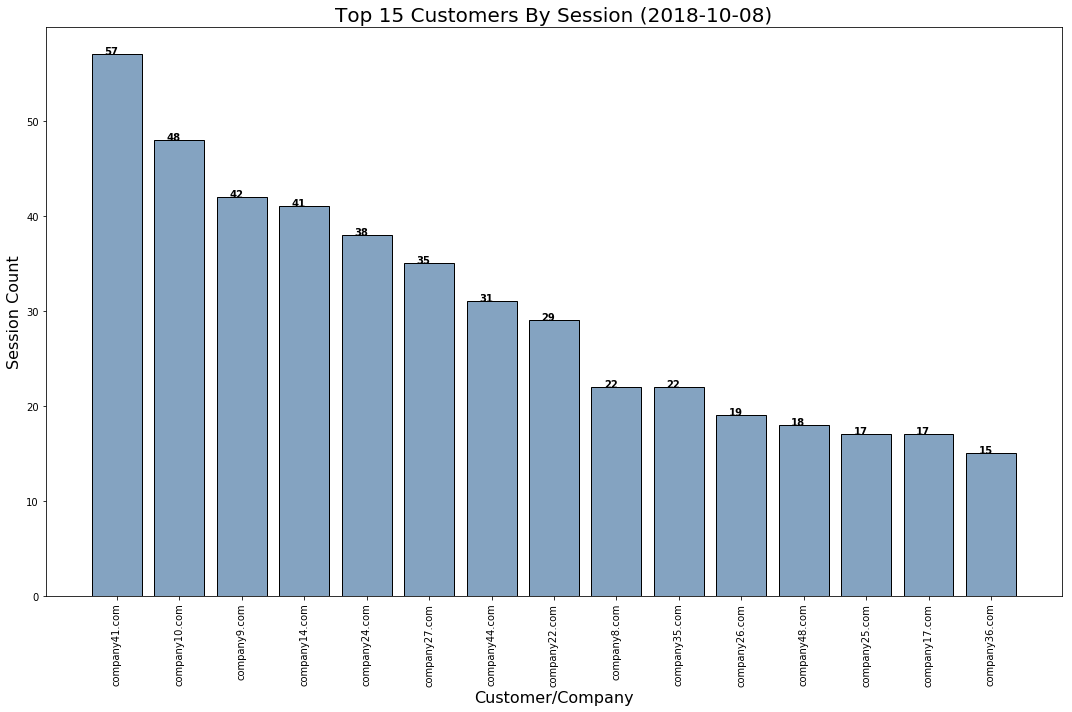

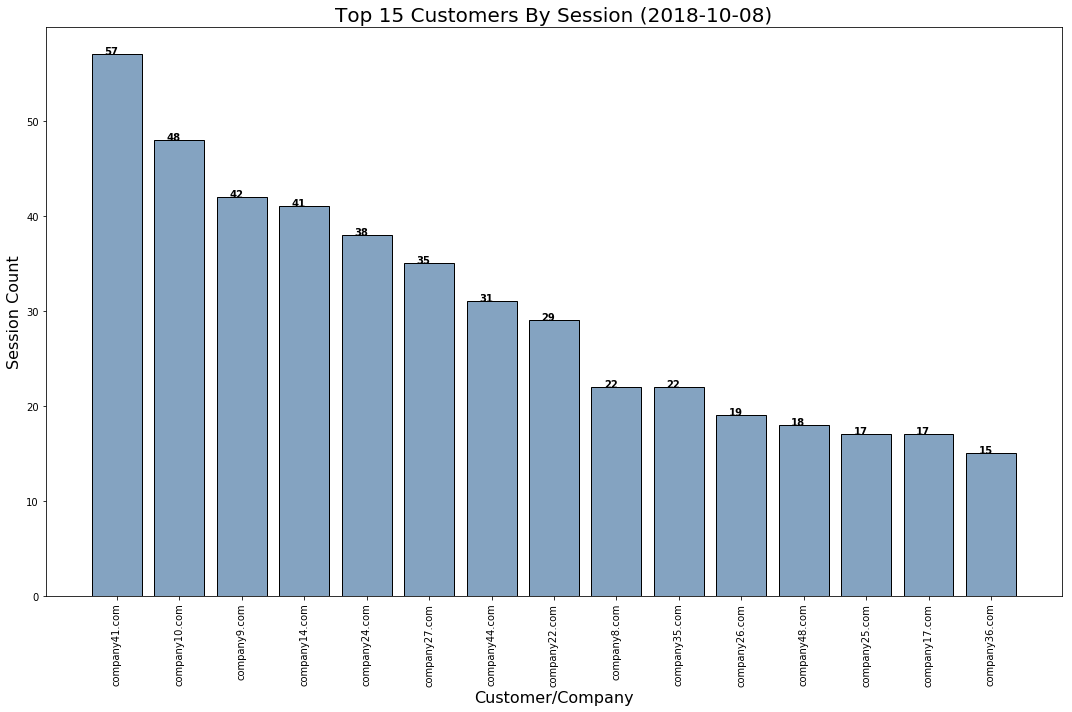

In [17]:

# Visually answering Top 15 Customers by Session Count

# Plotting the graph
plt.figure(figsize=(15,10))
y_pos = np.arange(len(company_bysession_df["Domain"]))
plt.bar(y_pos, company_bysession_df["SessionCount"], color=(0.2, 0.4, 0.6, 0.6), edgecolor = 'black' )
plt.xticks(y_pos, company_bysession_df["Domain"], rotation='vertical')
# Setting value label for each bar
for i, v in enumerate(company_bysession_df["SessionCount"]):
    plt.text(i-.20, v+.020, v, color='black', fontweight='bold')
# Setting title, grid and X and Y axis labels
plt.xlabel("Customer/Company",fontsize=16)
plt.ylabel("Session Count", fontsize=16)
plt.title(f'Top 15 Customers By Session ({datetime.now().date()})', fontsize=20)
plt.tight_layout()
# Save Figure
plt.savefig("../imgs/Top15CustomerBySession.png")
plt.show()


In [19]:
# Average Session Time Per Company
external_customers_df["PageInactiveTime"] = external_customers_df['PageDuration']- external_customers_df['PageActiveDuration']
session_info_df = external_customers_df[['Domain', 'UserEmail', 'UserId', 'PageDuration', 'PageActiveDuration',"PageInactiveTime" , 'PageUrl']]

session_info_df = session_info_df.groupby(["Domain","UserEmail", "UserId"]).head(1).reset_index(drop=True)
session_info_df = session_info_df.sort_values(["Domain","UserEmail", "UserId"])
session_info_df.head(5)

,Domain,UserEmail,UserId,PageDuration,PageActiveDuration,PageInactiveTime,PageUrl
119,company1.com,chad.tew@Company1.com,5099875769253888,35621,30044,5577,https://www.cloud.dataguru.com/li/search
0,company1.com,chad.tew@Company1.com,5650932471693312,20030,3459,16571,https://www.cloud.dataguru.com/li/
54,company1.com,chad.tew@Company1.com,5745257553592320,52610,43520,9090,https://www.cloud.dataguru.com/li/
217,company10.com,james.knueven@Company10.com,5070754280374272,4889492,196689,4692803,https://www.cloud.dataguru.com/dataType-UI/?or...
422,company10.com,james.knueven@Company10.com,5076154207698944,1501676,4867,1496809,https://www.cloud.dataguru.com/dataType-UI/#/d...


In [20]:
# Get average session time per Company in seconds
session_info_df = session_info_df.groupby(["Domain"])
avg_session_info_df = session_info_df['PageDuration','PageActiveDuration',"PageInactiveTime"].mean()
avg_session_info_df = avg_session_info_df.rename(columns={
                       'PageDuration': 'AverageSessionTime (Mins)',
                       'PageActiveDuration': 'AverageActiveSessionTime (Mins)',
                        'PageInactiveTime':'AverageInActiveSessionTime (Mins)'})
avg_session_info_df.head(10)

,AverageSessionTime (Mins),AverageActiveSessionTime (Mins),AverageInActiveSessionTime (Mins)
Domain,,,
company1.com,3.608700e+04,25674.333333,1.041267e+04
company10.com,2.291941e+06,177536.083333,2.114405e+06
company11.com,8.223473e+05,187558.333333,6.347890e+05
company12.com,3.062218e+06,402044.666667,2.660174e+06
company13.com,2.090006e+06,45316.666667,2.044690e+06
company14.com,1.291854e+06,181686.853659,1.110167e+06
company15.com,6.562460e+05,24982.200000,6.312638e+05
company16.com,9.093740e+04,37906.200000,5.303120e+04
company17.com,2.708888e+06,431162.588235,2.277726e+06


In [21]:
### Trying to add more columns for calculation speciall ideal time 
company_session_merge_df = pd.merge(company_bysession_df, avg_session_info_df, on="Domain",how ="left")
company_session_merge_df.head(10)

,Domain,SessionCount,AverageSessionTime (Mins),AverageActiveSessionTime (Mins),AverageInActiveSessionTime (Mins)
0,company41.com,57,7.438626e+06,219182.719298,7.219443e+06
1,company10.com,48,2.291941e+06,177536.083333,2.114405e+06
2,company9.com,42,1.168684e+06,218631.404762,9.500529e+05
3,company14.com,41,1.291854e+06,181686.853659,1.110167e+06
4,company24.com,38,3.388779e+06,402912.842105,2.985866e+06
5,company27.com,35,1.571201e+06,207425.514286,1.363775e+06
6,company44.com,31,9.889472e+05,116545.032258,8.724022e+05
7,company22.com,29,2.326947e+06,373954.793103,1.952993e+06
8,company8.com,22,2.226720e+06,415543.727273,1.811176e+06
9,company35.com,22,1.377183e+06,197441.409091,1.179742e+06


In [22]:


company_session_merge_df["SessionCount_Rank"]= company_session_merge_df["SessionCount"].rank(method='dense')
company_session_merge_df["AverageSessionTime_Rank"]= company_session_merge_df["AverageSessionTime (Mins)"].rank(method='dense')
company_session_merge_df["AverageActiveSessionTime"]= company_session_merge_df["AverageActiveSessionTime (Mins)"].rank(method='dense')
company_session_merge_df["AvgInactive_Rank"] = company_session_merge_df['AverageInActiveSessionTime (Mins)'].rank(method='dense')

weight_Col1=company_session_merge_df["SessionCount_Rank"]
weight_Col2=company_session_merge_df["AverageSessionTime_Rank"]
weight_Col3=company_session_merge_df["AverageActiveSessionTime"]
weight_Col4=company_session_merge_df["AvgInactive_Rank"]

company_session_merge_df["ActiveCustomer_score"]= ((weight_Col1*0.6 + weight_Col2*0.2+
                                                    weight_Col3*0.5 - weight_Col4*0.3)).rank(method='min')

company_session_merge_df.sort_values("ActiveCustomer_score", ascending=False,inplace =True)

        
        
customer_rank_df= company_session_merge_df[['Domain', 'SessionCount', 'AverageSessionTime (Mins)',
      'AverageActiveSessionTime (Mins)', 'AverageInActiveSessionTime (Mins)','ActiveCustomer_score']]

customer_rank_df['AverageSessionTime (Mins)'] = round(customer_rank_df['AverageSessionTime (Mins)']/1000/60 ,2)
customer_rank_df['AverageActiveSessionTime (Mins)'] = round(customer_rank_df['AverageActiveSessionTime (Mins)']/1000/60 ,2)
customer_rank_df['AverageInActiveSessionTime (Mins)'] = round(customer_rank_df['AverageInActiveSessionTime (Mins)']/1000/60 ,2)



customer_rank_df.reset_index(drop=True,inplace = True)

customer_rank_df["customer_Rank"] =customer_rank_df.index
customer_rank_df["customer_Rank"] = customer_rank_df["customer_Rank"].apply(lambda x: x + 1)
 

top_15_customer_rank = customer_rank_df.head(15)
top_15_customer_rank

,Domain,SessionCount,AverageSessionTime (Mins),AverageActiveSessionTime (Mins),AverageInActiveSessionTime (Mins),ActiveCustomer_score,customer_Rank
0,company41.com,57,123.98,3.65,120.32,15.0,1
1,company9.com,42,19.48,3.64,15.83,14.0,2
2,company24.com,38,56.48,6.72,49.76,13.0,3
3,company14.com,41,21.53,3.03,18.50,12.0,4
4,company8.com,22,37.11,6.93,30.19,11.0,5
5,company10.com,48,38.20,2.96,35.24,10.0,6
6,company22.com,29,38.78,6.23,32.55,9.0,7
7,company27.com,35,26.19,3.46,22.73,8.0,8
8,company17.com,17,45.15,7.19,37.96,7.0,9
9,company35.com,22,22.95,3.29,19.66,6.0,10


57


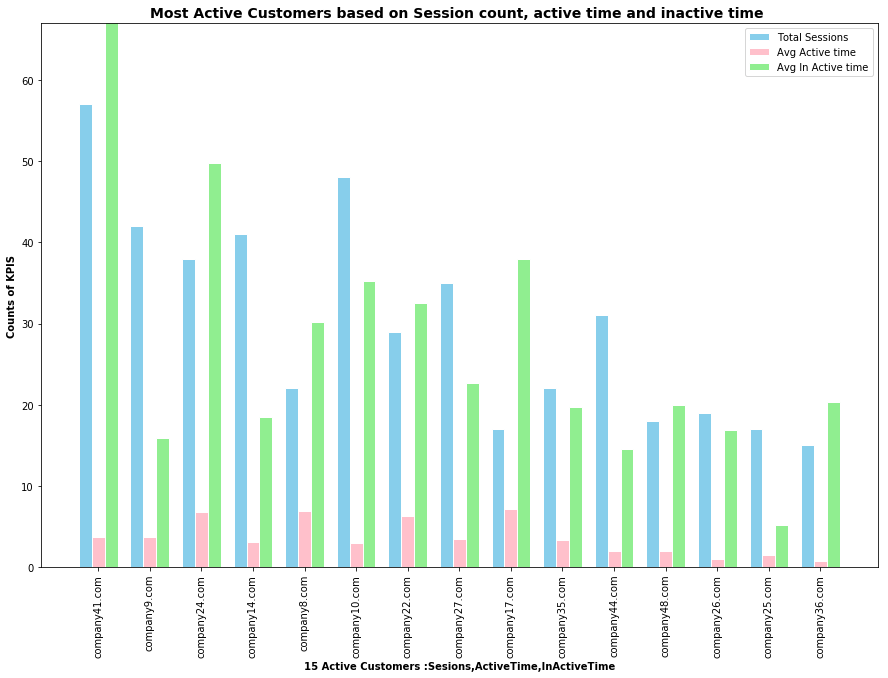

In [23]:
###AS working on stacked bar include 

plt.figure(figsize= (15,10))
sessionCount = top_15_customer_rank["SessionCount"]
avg_active = top_15_customer_rank["AverageActiveSessionTime (Mins)"]
avg_inactive= top_15_customer_rank["AverageInActiveSessionTime (Mins)"]
companies  = top_15_customer_rank["Domain"]
# set width of bar
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(sessionCount))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, sessionCount, color='skyblue', width=barWidth, edgecolor='white', label='Total Sessions')
plt.bar(r2,avg_active, color='pink', width=barWidth, edgecolor='white', label='Avg Active time')
plt.bar(r3, avg_inactive, color='lightgreen', width=barWidth, edgecolor='white', label='Avg In Active time')

# Add xticks on the middle of the group bars
plt.xlabel('15 Active Customers :Sesions,ActiveTime,InActiveTime', fontweight='bold')
plt.ylabel('Counts of KPIS',fontweight='bold')
plt.xticks([r + barWidth for r in range(len(sessionCount))], companies,rotation='vertical')
# Create legend & Show graphic

plt.title("Most Active Customers based on Session count, active time and inactive time ",fontsize =14,fontweight='bold')

ymax = sessionCount.max()
print(ymax)
plt.ylim(0,ymax +10)
plt.legend()
# Save Figure
plt.savefig("../imgs/Top15CustomerByKPIS.png")
plt.show()

In [24]:
### Now we want to see top used Services overall
# Setting data for most used services
most_used_services_df = external_customers_df.groupby(["serviceName"])["PageUrl"].count()
most_used_services_df = most_used_services_df.reset_index(['serviceName'])
most_used_services_df = most_used_services_df.rename(columns={"PageUrl": "PageUrlCount"})
most_used_services_df

,serviceName,PageUrlCount
0,Data Logging,4377
1,Data Package,61864
2,SDK,12050


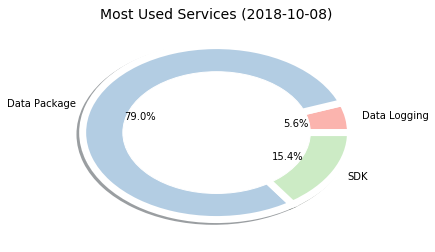

In [25]:


# Visually answering Most Used Services

# Plotting the graph
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(most_used_services_df["PageUrlCount"], labels=most_used_services_df["serviceName"], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, colors=Pastel1_7.hex_colors, autopct="%1.1f%%", shadow=True)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title(f'Most Used Services ({datetime.now().date()})', fontsize=14)

# Save Figure
plt.savefig("../imgs/MostUsedServices.png")
plt.show()

In [26]:

## Now we need to answer Most Popular Service among our Active Customers
# Setting up data for Most Popuylar Service among our Active Customers

company_byservice_df = external_customers_df.groupby(["Domain", "serviceName"])["PageUrl"].count()
company_byservice_df = company_byservice_df.reset_index()
company_byservice_df = company_byservice_df.rename(columns={"PageUrl": "PageCount"})

DomainList = []
DomainList= top_15_customer_rank.Domain   

company_byservice_df = company_byservice_df[company_byservice_df.Domain.isin(DomainList)]


company_byservice_df

,Domain,serviceName,PageCount
1,company10.com,Data Package,4395
2,company10.com,SDK,188
7,company14.com,Data Package,3611
8,company14.com,SDK,34
12,company17.com,Data Package,4400
13,company17.com,SDK,459
24,company22.com,Data Package,5539
25,company22.com,SDK,2094
28,company24.com,Data Logging,149
29,company24.com,Data Package,9487


In [27]:
### Setting data in pivot for graphs

pivot_df = company_byservice_df.pivot(index ="Domain",columns = "serviceName",values = "PageCount")

pivot_df.fillna(0, inplace=True)
pivot_df

serviceName,Data Logging,Data Package,SDK
Domain,,,
company10.com,0.0,4395.0,188.0
company14.com,0.0,3611.0,34.0
company17.com,0.0,4400.0,459.0
company22.com,0.0,5539.0,2094.0
company24.com,149.0,9487.0,1766.0
company25.com,765.0,0.0,0.0
company26.com,0.0,707.0,110.0
company27.com,0.0,2449.0,1004.0
company35.com,24.0,2682.0,274.0


<Figure size 1080x1440 with 0 Axes>

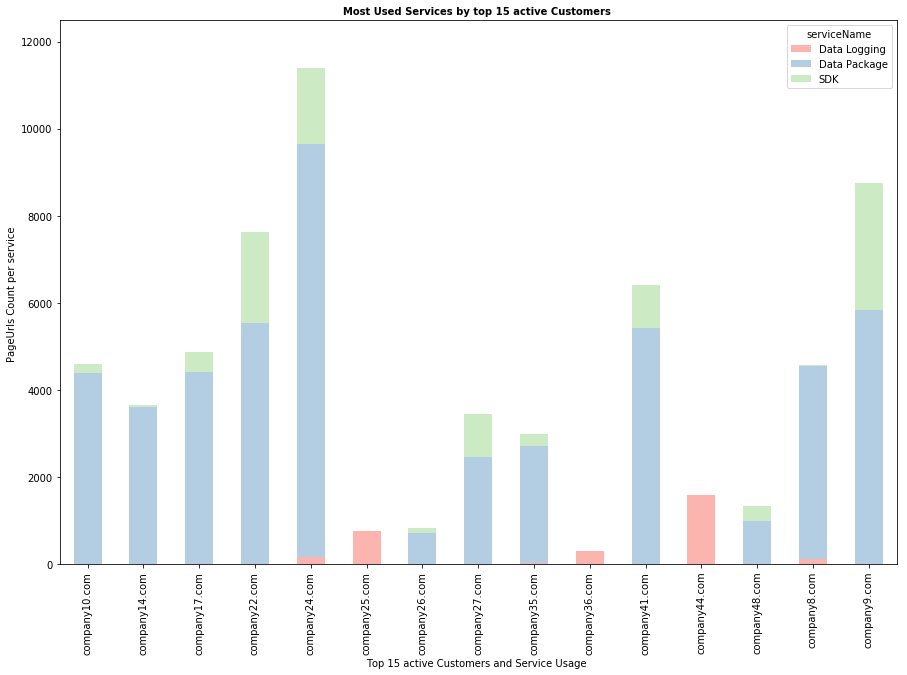

In [28]:
## Creating stacked graph
plt.figure(figsize= (15,20))
pivot_df.plot.bar(stacked=True,colors=Pastel1_7.hex_colors,figsize=(15,10))
#pivot_df.plot.bar(stacked=True)
plt.xlabel("Top 15 active Customers and Service Usage ")
plt.ylabel("PageUrls Count per service ")
plt.title("Most Used Services by top 15 active Customers ",fontsize =10,fontweight='bold')
plt.ylim(0,pivot_df["Data Package"].max() +3000)
# Save Figure
plt.savefig("../imgs/Top15Customer_ServiceUsage.png")
plt.show()

In [29]:
## Now we need to answer Most Popular Browsers with our customers 
# Checking the types of Browsers used by customers
Popular_Browser_df = external_customers_df["PageBrowser"].unique()  
# Setting data for Most Popular Browsers 
Popular_Browser_df = external_customers_df.groupby(["PageBrowser"])["Domain"].count()
Popular_Browser_df = Popular_Browser_df.sort_values(ascending=False)
Popular_Browser_df = Popular_Browser_df.reset_index()
Popular_Browser_df = Popular_Browser_df.rename(columns={"Domain": "UserCount"})
Popular_Browser_df

,PageBrowser,UserCount
0,Chrome,71304
1,Firefox,3385
2,Safari,2993
3,Microsoft Edge,531
4,Internet Explorer,78


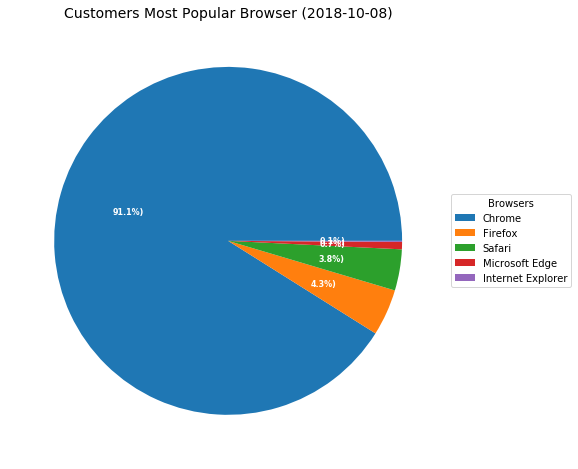

In [30]:
# Visually answering Most Popular Browser with our customers

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%)".format(pct, absolute)
wedges, texts, autotexts = ax.pie(Popular_Browser_df["UserCount"], autopct=lambda pct: func(pct, Popular_Browser_df["UserCount"]),
                                  textprops=dict(color="w"))
ax.legend(wedges, Popular_Browser_df["PageBrowser"],
          title="Browsers",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
plt.title(f'Customers Most Popular Browser ({datetime.now().date()})', fontsize=14)

# Save figure
plt.savefig("../imgs/MostPopularBrowserPie.png")
plt.show()

In [31]:
## Now we need to answer Most Popular Devices used by our customers 
# Setting data for Most Popular Devices 
Popular_Device_df=external_customers_df["PageDevice"].unique()
Popular_Device_df = external_customers_df.groupby(["PageDevice"])["Domain"].count()
Popular_Device_df = Popular_Device_df.sort_values(ascending=False)
Popular_Device_df = Popular_Device_df.reset_index()
Popular_Device_df = Popular_Device_df.rename(columns={"Domain": "UserCount"})
Popular_Device_df

,PageDevice,UserCount
0,Desktop,78217
1,Mobile,49
2,Tablet,25


###Observation -  This is quite obvious that most of the users are using Desktop to use our servcies .

In [32]:
### Now we are answering Page Analysis 

page_counts_df = external_customers_df.groupby(["PageUrl_Norm"])["PageUrl"].count().sort_values(ascending=False)
page_counts_df  = pd.DataFrame(page_counts_df ).rename(columns={"PageUrl": "PageCount"})
top_10_urls = page_counts_df.head(10)

top_10_urls.reset_index(inplace = True)
top_10_urls


,PageUrl_Norm,PageCount
0,dataType-UI/#/blueprint-ui;ash=/blueprint,13494
1,dataType-UI/#/data-provision-ui;ash=/endpoints,4725
2,dataType-UI/#/dataType-ui;ash=/dataType,3686
3,dataType-UI/#/data-provision-ui;ash=/networkPr...,3581
4,dataType-UI/#/data-provision-ui;ash=/cloudZones,3486
5,dataType-UI/#/data-provision-ui;ash=/projects,3201
6,dataType-UI/#/data-provision-ui;ash=/quickstart,3108
7,dataType-UI/#/blueprint-ui;ash=/blueprints,2904
8,catalog/#/administration/contentSources,2689
9,catalog/#/administration/content,2466


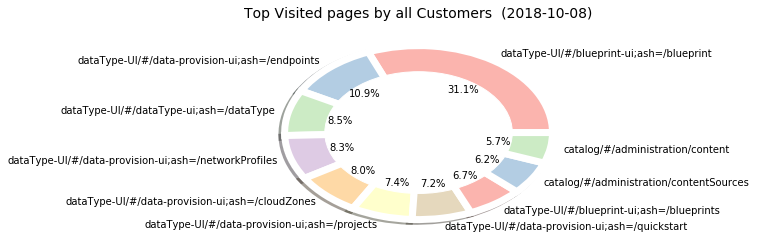

In [33]:
# Visually answering number of events per PageURL

# Plotting the graph
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(top_10_urls["PageCount"], labels=top_10_urls["PageUrl_Norm"], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, colors=Pastel1_7.hex_colors, autopct="%1.1f%%", shadow=True)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title(f'Top Visited pages by all Customers  ({datetime.now().date()})', fontsize=14)

# Save Figure
plt.savefig("../imgs/TopVisitedPages_Overall.png")
plt.show()

In [34]:
### Top Visted pages by our top 15 active customers 
top3_Customer = customer_rank_df.head(2)
DomainList= top3_Customer.Domain 
DomainList
customer_pages= external_customers_df.groupby(["Domain", "PageUrl_Norm"]).count()["PageUrl"]
customer_pages=customer_pages.reset_index()

customer_pages.rename(columns ={"PageUrl":"PageCount"} ,inplace =True)

comp_dfs= []
for company in DomainList:
    comp_df = customer_pages[customer_pages["Domain"]==company]
    comp_df = comp_df.sort_values("PageCount",ascending=False).head(10)
    comp_df.reset_index(drop=True,inplace = True)
    comp_dfs.append(comp_df)
print(comp_dfs[1])   

## you have a list  of dfs comp_dfs

         Domain                                       PageUrl_Norm  PageCount
0  company9.com          dataType-UI/#/blueprint-ui;ash=/blueprint       1442
1  company9.com                   catalog/#/administration/content       1356
2  company9.com            dataType-UI/#/dataType-ui;ash=/dataType        589
3  company9.com            catalog/#/administration/contentSources        440
4  company9.com         dataType-UI/#/blueprint-ui;ash=/blueprints        367
5  company9.com                 catalog/#/library/f1b218da7b74ce5d        319
6  company9.com  dataType-UI/#/extensibility-ui;ash=/subscriptions        314
7  company9.com                                  catalog/#/library        300
8  company9.com    dataType-UI/#/data-provision-ui;ash=/cloudZones        277
9  company9.com     dataType-UI/#/data-provision-ui;ash=/endpoints        246


In [32]:
### Create function to plot the graph for one of teh copmany and put in a loop